In [1]:
from typing import Tuple
import numpy as np
import torch as t
from torch.distributions import uniform
from diffusion import diffuse
from diffusion_gumbel import diffuse_STE
from IPython.display import Image
from IPython import display
import matplotlib.pyplot as plt
from tqdm import tqdm

c:\Users\jsche\anaconda3\envs\torchenv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
grid = t.zeros((2,50,50))
grid[:,15:30] = 200
print(t.sum(grid))

tensor(300000.)


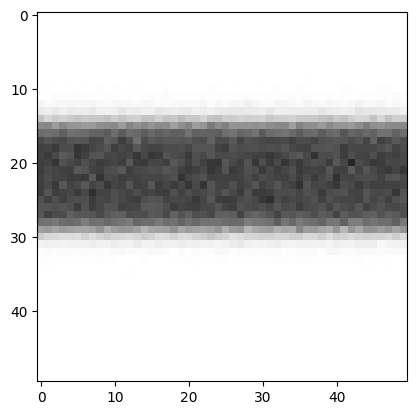

100%|██████████| 2000/2000 [00:10<00:00, 188.65it/s]


tensor(300000.)

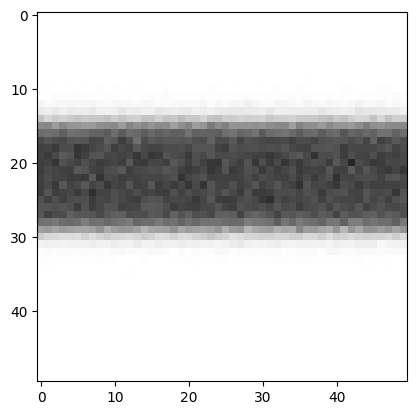

In [3]:
N = 256 
for i in tqdm(range(2_000)):
  if i % 100 == 0:
    display.clear_output(wait=True)
    plt.imshow(grid[0], cmap="Greys", interpolation="nearest", vmin=0, vmax=256)
    display.display(plt.gcf())
  grid = diffuse_STE(grid, N, t.tensor(0.5), t.tensor(0.5))
t.sum(grid)

In [4]:
grid = t.zeros((2,50,50))
grid[:,15:30] = 200
print(t.sum(grid))

tensor(300000.)


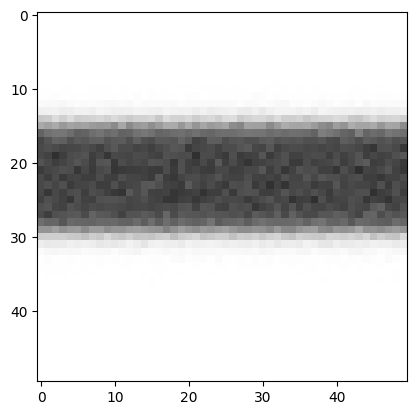

100%|██████████| 2000/2000 [00:06<00:00, 303.84it/s]


tensor(300000.)

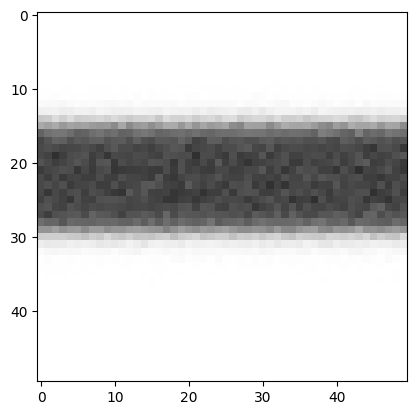

In [5]:
N = 256 
for i in tqdm(range(2_000)):
  if i % 100 == 0:
    display.clear_output(wait=True)
    plt.imshow(grid[0], cmap="Greys", interpolation="nearest", vmin=0, vmax=256)
    display.display(plt.gcf())
  grid = diffuse(grid, N, 0.5, 0.5)
t.sum(grid)